<a href="https://colab.research.google.com/github/cindyhfls/NMA_DL_2021_project/blob/main/simulation_independent_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Focus on what matters: inferring low-dimensional dynamics from neural recordings

**By Neuromatch Academy**

__Content creators:__ Marius Pachitariu, Pedram Mouseli, Lucas Tavares, Jonny Coutinho, 
Blessing Itoro, Gaurang Mahajan, Rishika Mohanta

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective: 
It is very difficult to interpret the activity of single neurons in the brain, because their firing patterns are noisy, and it is not clear how a single neuron can contribute to cognition and behavior. However, neurons in the brain participate in local, regional and brainwide dynamics. No neuron is isolated from these dynamics, and much of a single neuron's activity can be predicted from the dynamics. Furthermore, only populations of neurons as a whole can control cognition and behavior. Hence it is crucial to identify these dynamical patterns and relate them to stimuli or behaviors. 

In this notebook, we generate simulated data from a low-dimensional dynamical system and then use seq-to-seq methods to predict one subset of neurons from another. This allows us to identify the low-dimensional dynamics that are sufficient to explain the activity of neurons in the simulation. The methods described in this notebook can be applied to large-scale neural recordings of hundreds to tens of thousans of neurons, such as the ones from the NMA-CN course.

---
# Setup

In [3]:
# Imports
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import math
from sklearn.linear_model import LinearRegression

In [4]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
def pearson_corr_tensor(input, output):
  rpred = output.detach().cpu().numpy()
  rreal = input.detach().cpu().numpy()
  rpred_flat = np.ndarray.flatten(rpred)
  rreal_flat = np.ndarray.flatten(rreal)
  corrcoeff = np.corrcoef(rpred_flat, rreal_flat)
  return corrcoeff[0,1]

In [7]:
#@title Set random seed

#@markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

**Note:** If `cuda` is not enabled, go to `Runtime`--> `Change runtime type` and in `Hardware acceleration` choose `GPU`. 

---
# Simulate some data from a linear dynamical system

In [8]:
# set the seed
np.random.seed(42)

# 100 trials is typical of neural data
ntrials = 100

#we simulate 200 neurons
NN = 300
NN1 = 200
NN2 = NN-NN1

# we will pretend like every "bin" is 10ms, so the trial length is 2500ms
NT = 250

# let's use 10 latent components
ncomp = 10

# this is the recurrent dynamics matrix, which we made diagonal for simplicity
# values have to be smaller than 1 for stability
A0_NN1 =  np.diag(.8 + .2 * np.random.rand(ncomp,))
A0_NN2 =  np.diag(.8 + .2 * np.random.rand(ncomp,))

# this is the projection matrix from components to neurons
C0_NN1 = .025 * np.random.randn(ncomp, NN1)
C0_NN2 = .025 * np.random.randn(ncomp, NN2)

# We generate the dynamics of the low-d system. We initialize the latent state.

# start by initializing the latents
y       = 2 *np.random.randn(ncomp)
y2       = 2 * np.random.randn(ncomp) # add the inputs here

latents = np.zeros((NT, ntrials, ncomp))
latents2 = np.zeros((NT, ntrials, ncomp))
# we run the dynamics forward and add noise (or "innovations") at each timestep

for t in range(NT):
  y2 = y2 @ A0_NN2 +  np.random.randn(ntrials, ncomp) 
  y = y @ A0_NN1 +  np.random.randn(ntrials, ncomp) 
  latents[t] = y
  latents2[t] = y2

# we now project the latents to the neuron space and threshold to generate firing rates
rates = np.maximum(0, latents @ C0_NN1)
rates2 = np.maximum(0, latents2 @ C0_NN2)
# rates2 = np.maximum(0, np.random.randn(NT,ntrials,NN2))

# now we draw poisson counts to simulate the number of spikes a neuron fires randomly
x1 = np.random.poisson(rates)
x0 = np.random.poisson(rates2)


(250, 100, 200)


Text(0.5, 1.0, 'x0')

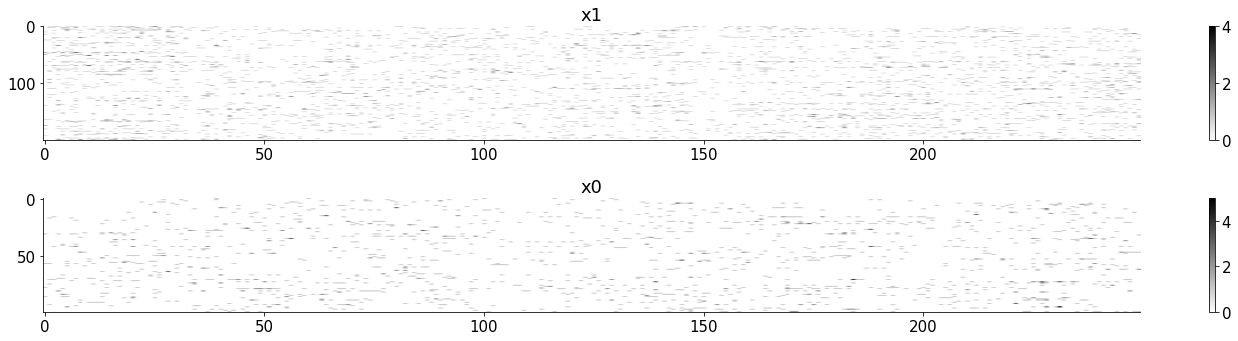

In [9]:
plt.figure(figsize = (20,5))
plt.subplot(2,1,1)
plt.imshow(x1[:,0,:].T,aspect = 'auto',cmap='gray_r')
plt.colorbar()
plt.title('x1')
plt.subplot(2,1,2)
plt.imshow(x0[:,0,:].T,aspect = 'auto',cmap='gray_r')
plt.colorbar()
print(rates.shape)
plt.title('x0')

In [10]:

x0 = torch.from_numpy(x0).to(device).float()
x1 = torch.from_numpy(x1).to(device).float()

In [11]:
# we separate the neuron data into two populations: MOs and TH
# x0 = torch.from_numpy(x[:, :, :200]).to(device).float() # dims: ntimebins * ntrials * nneurons
# x1 = torch.from_numpy(x[:, :, 200:]).to(device).float()

trial_divide = [math.floor(ntrials*0.6),math.floor(ntrials*0.9)]

x0_train = x0[:,:trial_divide[0],:]
x0_val = x0[:,trial_divide[0]:trial_divide[1],:]
x0_test = x0[:,trial_divide[1]:,:]

x1_train = x1[:,:trial_divide[0],:]
x1_val = x1[:,trial_divide[0]:trial_divide[1],:]
x1_test = x1[:,trial_divide[1]:,:]

NN1 = x1.shape[-1]
NN2 = x0.shape[-1]


#Our RNN model

In [13]:
class Net_singleinput(nn.Module): # our model
  def __init__(self, ncomp, NN2, NN1, bidi=True): # NN2 is input dim, NN1 is output dim
    super(Net_singleinput, self).__init__()

    # play with some of the options in the RNN!
    self.rnn1 = nn.RNN(NN2, ncomp, num_layers = 1, dropout = 0, # MO
                      bidirectional = bidi, nonlinearity = 'tanh')

    self.fc = nn.Linear(ncomp,NN1)

  def forward(self, x0,x1):
    y =  self.rnn1(x0)[0] # ncomp THs

    if self.rnn1.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)
 
    return z, q

# train model MO->MO only


In [14]:
# @title train loop
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

def train(net,train_input,train_output,val_input,val_output,niter = 1000):
  set_seed(42)
  optimizer = torch.optim.Adam(net.parameters(), lr=.005)
  training_cost = []
  val_cost = []
  for k in range(niter):
    ### training
    optimizer.zero_grad()
    # the network outputs the single-neuron prediction and the latents
    z,_= net(train_input,train_output)
    # our log-likelihood cost
    cost = Poisson_loss(z, train_output).mean()
    # train the network as usual
    cost.backward()
    optimizer.step()
    training_cost.append(cost.item())

    ### test on validation data
    z_val,_ = net(val_input,val_output)
    cost = Poisson_loss(z_val, val_output).mean()
    val_cost.append(cost.item())

    if k % 100 == 0:
      print(f'iteration {k}, cost {cost.item():.4f}')
    
  return training_cost,val_cost

In [15]:
net_MOMO = Net_singleinput(ncomp, NN1, NN1, bidi = False).to(device)
net_MOMO.fc.bias.data[:] = x1.mean((0,1))

training_cost_MOMO,val_cost_MOMO = train(net_MOMO,x1_train,x1_train,x1_val,x1_val,niter = 1000) # train

Random seed 42 has been set.
iteration 0, cost 0.4759
iteration 100, cost 0.2388
iteration 200, cost 0.2245
iteration 300, cost 0.2204
iteration 400, cost 0.2187
iteration 500, cost 0.2182
iteration 600, cost 0.2180
iteration 700, cost 0.2179
iteration 800, cost 0.2178
iteration 900, cost 0.2177


# train model TH->MO only

In [16]:
net_THMO = Net_singleinput(ncomp, NN2, NN1, bidi = False).to(device)
net_THMO.fc.bias.data[:] = x1.mean((0,1))

training_cost_THMO,val_cost_THMO = train(net_THMO,x0_train,x1_train,x0_val,x1_val,niter = 1000) # train

Random seed 42 has been set.
iteration 0, cost 0.4351
iteration 100, cost 0.3293
iteration 200, cost 0.3297
iteration 300, cost 0.3313
iteration 400, cost 0.3298
iteration 500, cost 0.3300
iteration 600, cost 0.3338
iteration 700, cost 0.3348
iteration 800, cost 0.3378
iteration 900, cost 0.3309


Text(0.5, 0, 'epochs')

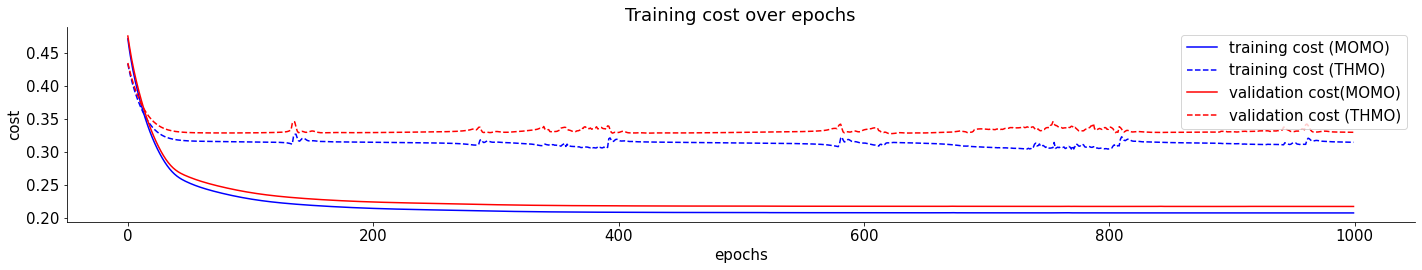

In [30]:
#@title plot the training side-by-side
plt.plot(training_cost_MOMO,'b')
plt.plot(training_cost_THMO,'b',linestyle = '--')
plt.plot(val_cost_MOMO,'r')
plt.plot(val_cost_THMO,'r',linestyle = '--')

plt.legend(['training cost (MOMO)','training cost (THMO)','validation cost(MOMO)',
            'validation cost (THMO)'])
plt.title('Training cost over epochs')
plt.ylabel('cost')
plt.xlabel('epochs')


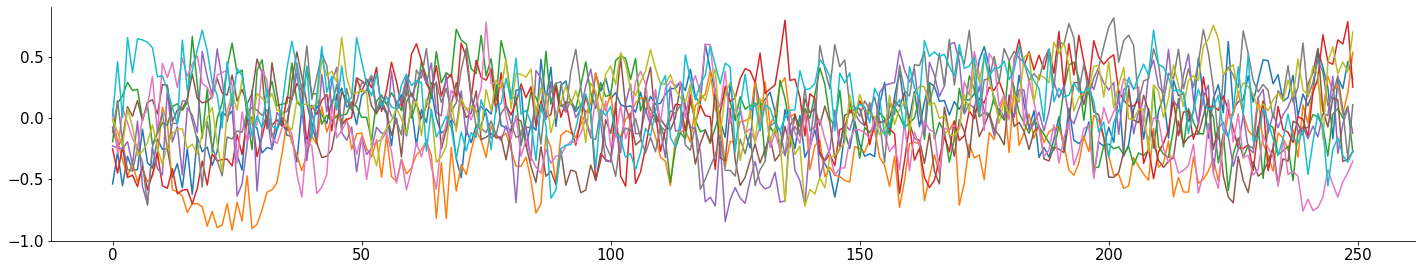

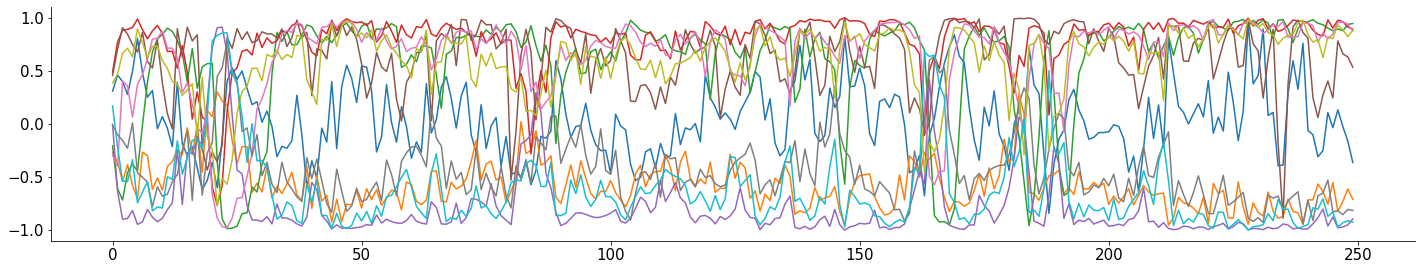

In [17]:
# see if the latents are correlated?
z_MOMO,y_MOMO= net_MOMO(x1_train,x1_train)
plt.figure()
plt.plot(y_MOMO[:,0,:].detach().cpu().numpy())

z_THMO,y_THMO= net_THMO(x0_train,x1_train)
plt.figure()
plt.plot(y_THMO[:,0,:].detach().cpu().numpy())

In [18]:
print(F.cosine_similarity(z_MOMO.flatten(start_dim = 0,end_dim = 1).T,z_THMO.flatten(start_dim = 0,end_dim = 1).T).mean())
print(F.cosine_similarity(z_MOMO.flatten(start_dim = 0,end_dim = 1).T,x1_train.flatten(start_dim = 0,end_dim = 1).T).mean())
print(F.cosine_similarity(z_THMO.flatten(start_dim = 0,end_dim = 1).T,x1_train.flatten(start_dim = 0,end_dim = 1).T).mean())


tensor(0.4890, grad_fn=<MeanBackward0>)
tensor(0.5643, grad_fn=<MeanBackward0>)
tensor(0.2718, grad_fn=<MeanBackward0>)


Text(0.5, 1.0, 'cosine_similarity by neuron')

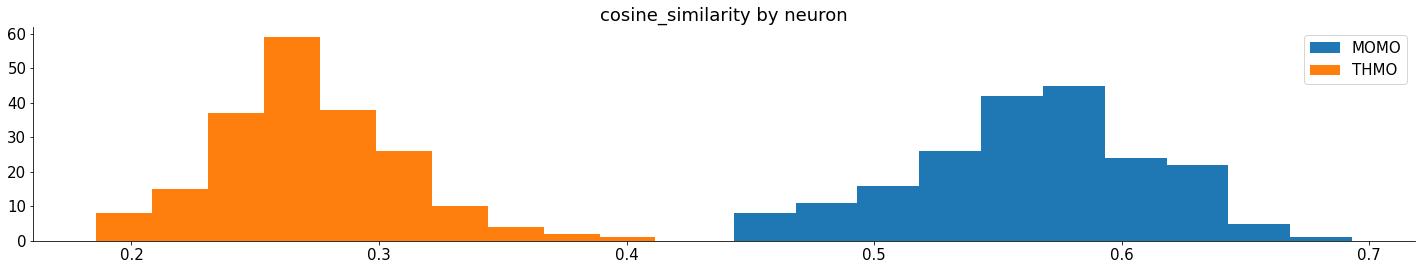

In [19]:
plt.hist(F.cosine_similarity(z_MOMO.flatten(start_dim = 0,end_dim = 1).T,x1_train.flatten(start_dim = 0,end_dim = 1).T).detach().cpu().numpy())
plt.hist(F.cosine_similarity(z_THMO.flatten(start_dim = 0,end_dim = 1).T,x1_train.flatten(start_dim = 0,end_dim = 1).T).detach().cpu().numpy())
plt.legend(('MOMO','THMO'))
plt.title('cosine_similarity by neuron')

In [20]:
def regress_tensor(X,y):
  X = X.detach().cpu().numpy()
  y = y.flatten().detach().cpu().numpy().reshape(-1,1)
  # print(X.shape)
  # print(y.shape)
  model = LinearRegression()
  model.fit(X, y)
  r_sq = model.score(X, y)
  print('coefficient of determination:', r_sq)
  return r_sq

In [22]:
rsqmat = []
for i in range(ncomp):
  rsqmat.append(regress_tensor(y_THMO.flatten(start_dim = 0,end_dim = 1),y_MOMO[:,:,i].reshape(-1,1)))

coefficient of determination: 0.017018176650024475
coefficient of determination: 0.0067456365422826625
coefficient of determination: 0.016406836205302366
coefficient of determination: 0.004993979583833297
coefficient of determination: 0.008849374824956735
coefficient of determination: 0.01125753870006996
coefficient of determination: 0.017174395265480036
coefficient of determination: 0.016759606010884442
coefficient of determination: 0.01443203505831836
coefficient of determination: 0.014837686457399024


In [37]:
Avg_rsq = sum(rsqmat)/len(rsqmat)
print('Average Rsq for predicting the %i latents in THMO from a linear combination of %i latents in MOMO is %2.3f'%(ncomp,ncomp,Avg_rsq))
max_rsq = max(rsqmat)
print('Max Rsq for predicting the %i latents in THMO from a linear combination of %i latents in MOMO is %2.3f'%(ncomp,ncomp,max_rsq))

Average Rsq for predicting the 10 latents in THMO from a linear combination of 10 latents in MOMO is 0.013
Max Rsq for predicting the 10 latents in THMO from a linear combination of 10 latents in MOMO is 0.017
